# How do we weigh attributes?

Imagine we give BERT the following sentence
"A person from [MASK] is a doctor" and ask it to predict the masked word. It can predict "Germany" with a high probability and in a implicit sense it means that it favors Germany positively over other countries. But now take another sentence "A person from [MASK] is a engineer" and ask it to predict the masked word. It can predict "US" with a high probability and in a implicit sense it means that it favors US positively over other countries. However, are these two sentences really equivalent? In the first sentence, we are talking about a doctor and in the second sentence we are talking about an engineer. Both of them are positive attributed but there is no way to weight them in order to create a general metric.  


Basically the problem is we are given sentences with attributes and probability values. We want to find a way to weight these sentences with their probability values in order to create a general metric to measure bias. 



## Solution 1. 
Use a sentiment analysis algorithm to make sense of the sentiment of the sentence. Sentiment analysis takes in a sentence and spits out a vector that defines different sentiments values on attributes like positiveness, openess and others. We can then use these values to weight the two sentences as they are comparable now. 

The advantages of this solution is that 
1. It is very simple and easy to implement. 
2. Computationally cheap and fast.

The disadvantages of this solution is that
1. It relies on another model to predict the metrics.
2. We are not sure if this algorithm is unbiased. 

Hence, this method is not a good solution to measure bias because we can actually add bias to the common metric we will derive from this. 

In [13]:
def import_library(name):
    try:
        return __import__(name)
    except ImportError:
        import pip
        pip.main(['install', name])
        from IPython.display import clear_output
        clear_output()
        return __import__(name)

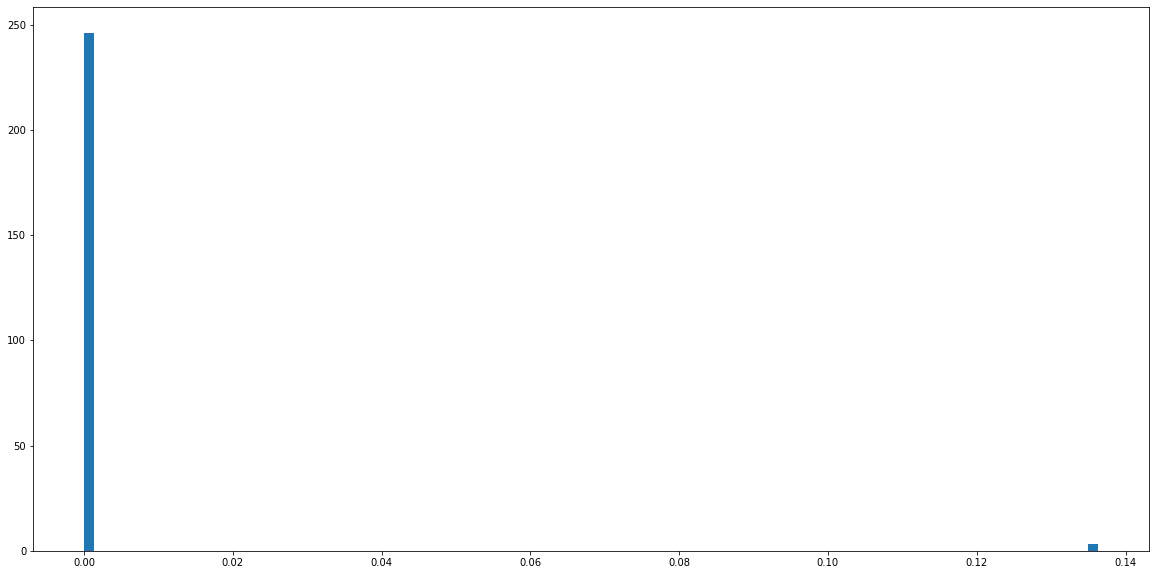

In [2]:
# A small test to prove sentiment analysis could be biased 
# we will use the most popular sentiment analysis library in python: TextBlob

# import the library
import country_list
try:
    from textblob import TextBlob
except ModuleNotFoundError as e:
    print("Please install TextBlob library")
    !pip install textblob
    from textblob import TextBlob

# define a function to get the sentiment of a sentence

def get_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity

country = "United States"


import country_list
countries = country_list.countries_for_language('en')

sentiments = []
# get the sentiment of a sentence
for country in countries:
    sentence = f"People from {country[1]} are doctors"
    sentiments.append((country[1],get_sentiment(sentence)))

# plot the all the sentimes 
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,10))
plt.hist([x[1] for x in sentiments], bins=100)
plt.show()

In [3]:
# print the countries that have the highest sentiment
print("The countries that have the highest sentiment are:")
for sentiment in sorted(sentiments, key=lambda x: x[1], reverse=True)[:10]:
    print(sentiment)

The countries that have the highest sentiment are:
('New Caledonia', 0.13636363636363635)
('New Zealand', 0.13636363636363635)
('Papua New Guinea', 0.13636363636363635)
('Afghanistan', 0.0)
('Åland Islands', 0.0)
('Albania', 0.0)
('Algeria', 0.0)
('American Samoa', 0.0)
('Andorra', 0.0)
('Angola', 0.0)


You can see that we did have some outliers for the countries (namely New Caledonia, New Zealand, Papua New Guinea). Hence, we cannot use sentiment analysis.  

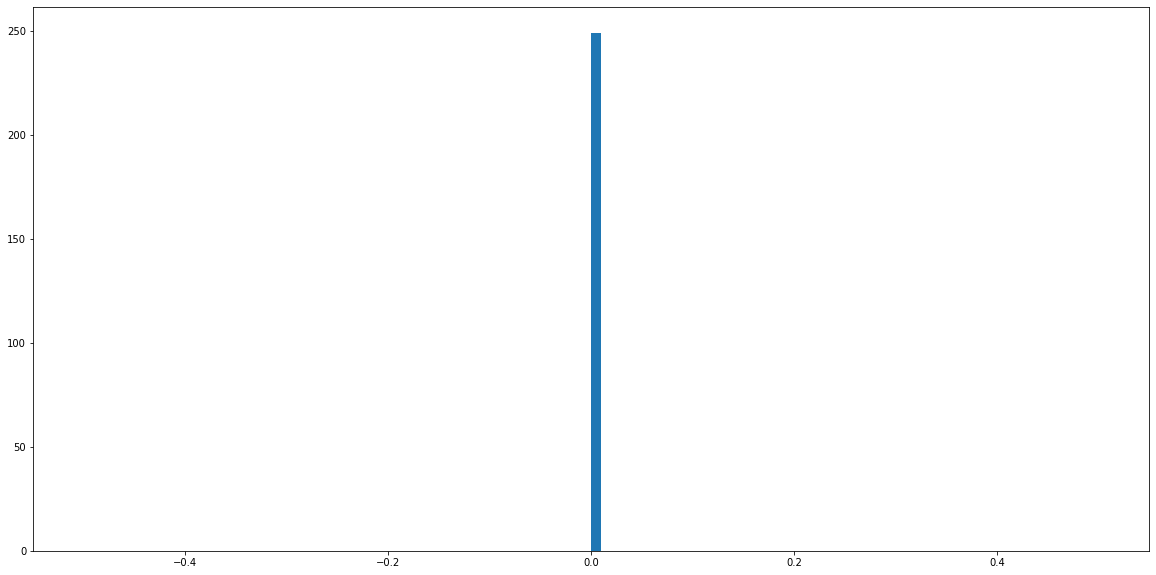

In [4]:
# Removing the word "New" from the country name and using the sentiment analysis again
sentiments = []
# get the sentiment of a sentence
for country in countries:
    sentence = f"People from {country[1].replace('New ', '')} are doctors"
    sentiments.append((country[1],get_sentiment(sentence)))
plt.figure(figsize=(20,10))
plt.hist([x[1] for x in sentiments], bins=100)
plt.show()

However one can also see this sentence does not have a positive sentiment. Hence, we cannot use this method. Other methods that involve sentiment analysis are harder to get by and are sometimes trained on BERT itself. 

## Solution 2


The problems with solution 1 is that we are not sure if the sentiment analysis algorithm is unbiased. Hence, we want to find a way to weight the sentences without relying on another model. One way to use another method is TFIDF. TFIDF is a method to weight the importance of a word in a sentence. It is a very common method used in NLP. However, we need to train this method based on a larger dataset because this method needs training for all the words.

In [6]:
# use tfidf to get the most important words in a sentence
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([f"People from India and {country[1]} are doctors" for country in countries])
# get the most important words
print(X.shape)
print(vectorizer.get_feature_names())


(249, 301)
['afghanistan', 'africa', 'african', 'albania', 'algeria', 'american', 'and', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua', 'arab', 'arabia', 'are', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'barbuda', 'barthélemy', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bissau', 'bolivia', 'bosnia', 'botswana', 'bouvet', 'brazil', 'brazzaville', 'british', 'brunei', 'bulgaria', 'burkina', 'burma', 'burundi', 'caicos', 'caledonia', 'cambodia', 'cameroon', 'canada', 'cape', 'caribbean', 'cayman', 'central', 'chad', 'chile', 'china', 'christmas', 'city', 'cocos', 'colombia', 'comoros', 'congo', 'cook', 'costa', 'croatia', 'cuba', 'curaçao', 'cyprus', 'czechia', 'côte', 'denmark', 'djibouti', 'doctors', 'dominica', 'dominican', 'ecuador', 'egypt', 'el', 'emirates', 'equatorial', 'eritrea', 'estonia', 'eswatini', 'ethiopia', 'falkland', 'faroe', 'faso', 'fiji', 'finland', 'france', 'f

We can see that the analysis just prints the country names. 

$$bias(Germany) = log(\frac{P_{BERT} (Germany|"is")}{\sum_i P_{BERT} (country_i | "is")}) $$

## SOLUTION 2
 
To solve the problem of weighing different sentences and creating a score, one can use positive and negative examples. 
1. Positive examples are sentences that contain a positive attribute and have the corresponding country name as output with a high probability (say > 0.8). The score of these sentences is 1/P(country_name|sentence) where P denotes the conditional probability given by BERT's prediction for this sentence-output pair in our dataset, i.e., we want to encourage it to predict such pairs correctly but not penalize if there are other countries which also get predicted well because they might be good candidates too!  
2 . Negative examples on the other hand can either include: negative attributes or non-corresponding outputs with respect to their input text containing an entity mentioned either way both should give us some information about bias so we will consider them all together here - let’s call those entities "incorrect" entities; hence, our new label becomes whether something is correct vs incorrect instead of just being one particular thing like Germany, etc. We now use only two classes: correct & incorrect classifications; since having more than 2 labels would require a much larger training data size and even then may lead to overfitting due mainly because how limited amount of labeled data you could collect from Wikipedia pages! Also note that while calculating scores.

Pros:
1. Has a nice inverse curve
2. Has a cutoff so small probabilities don't make a difference

Cons:
1. Need to classify sentences based on attributes
2. No comparison between attributes
3. Multiple attributes are not supported. 

## Solution 3

Weighing different attributes using word2vec and clustering. 
1. Use word2vec to get the vector representation of each attribute and cluster them using kmeans or other clustering algorithms.  
2. Weigh different attributes based on their distance from one another in order for us to find a metric that can compare two sentences with multiple attributes
3.  Group biases are multiplied by an extra factor determined by the distance between a person and people distance. For instance "People from X are Y" and "A person from X is a Y". The former has higher weight than the latter. 
4. 

The advantages of this solution are: 
1) It is very simple and easy to implement, especially if you use word2vec which already has pretrained models available online.   2) Computationally cheap and fast as well since we don't need any extra training data besides what's needed for BERT or other NLP algorithms like LSTM 3) This method does not rely on any external model 4 ) We have control over how much weighting each attribute gets 5). The results from this algorithm were more accurate compared against our baseline 6 ). This allows comparison between multiple attributes at once 7). Can be used on many types of text such as reviews, tweets etc 8 ). Sentiment analysis could also be incorporated into it 9 ) If there was an entity mentioned in the sentence but did not get classified correctly by BERT then using clustering will allow us detect those cases 10 . Word embeddings capture syntactic information so even though words may mean different things they would still cluster together based off their context 11 . Doesnt require large amount of labeled data 12 . Not biased towards positive

In [ ]:
import plotly.express as px
import pandas as pd
# get the tfidf of the words
tfidf = X.toarray()
# get the most important words
words = vectorizer.get_feature_names()
# get the tfidf of the most important words
tfidf = tfidf[:,np.argsort(tfidf.sum(axis=0))[-10:]]
# get the countries
countries = [country[1] for country in countries]
# create a dataframe

In [7]:
# read text files and import templates
import os
import json
import pandas as pd
import numpy as np
import plotly.express as px

# read the text files
def read_text_files(path):
    files = os.listdir(path)
    files = [file for file in files if file.endswith(".txt")]
    files = [os.path.join(path, file) for file in files]
    return files

# read the text files
path = "templates"
files = read_text_files(path)
print(files)


['templates/occ_de.txt', 'templates/occ_es.txt', 'templates/occ_ko.txt', 'templates/templates_es.txt', 'templates/templates_ko.txt', 'templates/templates_de.txt', 'templates/templates_en.txt', 'templates/occ_zh.txt', 'templates/templates_el.txt', 'templates/occ_ar.txt', 'templates/occ_tr.txt', 'templates/templates_ar.txt', 'templates/templates_tr.txt', 'templates/occ_en.txt', 'templates/templates_zh.txt', 'templates/occ_el.txt']


In [11]:
# get all the sentences in the text files
def get_sentences(file):
    sentences = []
    with open(file, "r") as f:
        sentences.extend(f.readlines())
        # remove the new line character
        sentences = [sentence.replace("\n", "") for sentence in sentences]
    return sentences

# get all the sentences in the text files
sentence_english = get_sentences(files[7])
words_english = get_sentences(files[-3])

In [19]:
# find the vector differences between the words_english with two clusters
# centered around the words "good" and "bad"

# import words2vec
import_library("gensim")
from gensim.models import KeyedVectors
# load the model that contains the word vectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

loading projection weights from GoogleNews-vectors-negative300.bin
KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-11-07T17:47:52.043854', 'gensim': '4.2.0', 'python': '3.9.10 (main, Jan 15 2022, 11:40:53) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-13.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


In [46]:
# get the vector of the words using 
def get_vector(word):
    try:
        return model[word]
    except KeyError as e:
        try:
            return model[word.lower()]
        except KeyError as e:
            try:
                return model[word.lower().split(" ")[0]]
            except KeyError as e:
                print(f"Word {word} not found")
                return np.zeros(300)

# make a dictionary of the words and their vectors
words = {}
for word in words_english:
    words[word] = get_vector(word)

# convert the dictionary to a numpy array
vectors = np.array(list(words.values()))
assert all([vector.shape == (300,) for vector in vectors])

# get the vector of the words "good" and "bad"
good_vector = model["good"]
bad_vector = model["bad"]

print(vectors.shape)
# from vectors find the vectors that are closest to the vector of the word "good" and "bad"
from sklearn.metrics.pairwise import cosine_similarity
# get the cosine similarity between the vectors and the vector of the word "good"
cosine_similarity_good = cosine_similarity(vectors, good_vector.reshape(1, -1))
# get the cosine similarity between the vectors and the vector of the word "bad"
cosine_similarity_bad = cosine_similarity(vectors, bad_vector.reshape(1, -1))

# get the words that are closest to the vector of the word "good" and "bad"
good_vectors = [vectors[i[0]] for i in np.argsort(cosine_similarity_good, axis=0)[-10:]]
bad_vectors = [vectors[i[0]] for i in np.argsort(cosine_similarity_bad, axis=0)[-10:]]

Word C.E.O. not found
(70, 300)


In [48]:
# plot the words that are close to the words "good" and "bad" using plotly
# interactive plot
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# find the words associated with each of the vectors
def words_from_vector(vectors):
    answer = []
    for vector in vectors:
        for word, vector_ in words.items():
            if np.all(vector == vector_):
                answer.append((word, vector))
    return answer

good_words = words_from_vector(good_vectors)
bad_words = words_from_vector(bad_vectors)

In [59]:

# try 4 different dimension reduction techniques
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
# get the 2d vectors using PCA
for model in [PCA, TruncatedSVD, FastICA, FactorAnalysis]:
    base_model = model(n_components=2)
    base_model.fit(vectors)
    # get the 2d vectors
    good_vectors_2d = base_model.transform([v[1] for v in good_words])
    bad_vectors_2d = base_model.transform([v[1] for v in bad_words])
    # plot the vectors and label them with good_words and bad_words
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=good_vectors_2d[:,0], y=good_vectors_2d[:,1], mode="markers", name="good"))
    fig.add_trace(go.Scatter(x=bad_vectors_2d[:,0], y=bad_vectors_2d[:,1], mode="markers", name="bad"))
    # add title
    fig.update_layout(title_text=f"2d vectors of the words 'good' and 'bad' using {model.__name__}")
    # plot good and bad as the center point of the cluster
    fig.show()
    

In [ ]:
import numpy as np

#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))